In [1]:
DATASET_PATH = '/group/avfedor-g00/datasets/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'

In [2]:
import sys
print(sys.executable)

/opt/anaconda/bin/python


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
SCRATCH_PATH = '/scratch/jjvandu/'

In [5]:
!ls $SCRATCH_PATH

In [6]:
import wfdb
import pandas as pd
import os
import matplotlib.pyplot as plt
import ast
import numpy as np
from torch.utils.data import Dataset

In [7]:
# Define paths
DATASET_PATH = '/group/avfedor-g00/datasets/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
metadata_path = os.path.join(DATASET_PATH, 'ptbxl_database.csv')
agg_path = os.path.join(DATASET_PATH, 'scp_statements.csv')

In [8]:
scp_statements = pd.read_csv('./scp_statements.csv')

In [9]:
metadata = pd.read_csv(metadata_path)
metadata.head(10)

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
5,6,19005.0,18.0,1,NaN,58.0,2.0,0.0,CS-12 E,1984-11-28 13:32:13,...,True,", V1",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00006_lr,records500/00000/00006_hr
6,7,16193.0,54.0,0,NaN,83.0,2.0,0.0,CS-12 E,1984-11-28 13:32:22,...,True,NaN,NaN,NaN,NaN,NaN,NaN,7,records100/00000/00007_lr,records500/00000/00007_hr
7,8,11275.0,48.0,0,NaN,95.0,2.0,0.0,CS-12 E,1984-12-01 14:49:52,...,True,", II,AVF",", I-AVF,",NaN,NaN,NaN,NaN,9,records100/00000/00008_lr,records500/00000/00008_hr
8,9,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr
9,10,9456.0,22.0,1,NaN,56.0,2.0,0.0,CS-12 E,1984-12-12 14:12:46,...,True,NaN,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00010_lr,records500/00000/00010_hr


In [10]:
from tqdm import tqdm
from skimage import io, transform
from torchvision import transforms, utils

import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [11]:
# Define function to load raw data
def load_raw_data(df, sampling_rate, dataset_path):
    # Determine the filename column based on the sampling rate
    filenames = df.filename_lr if sampling_rate == 100 else df.filename_hr
    print (len(filenames))
    # Load the ECG signals
    data = [wfdb.rdsamp(os.path.join(dataset_path, filename))[0] for filename in tqdm(filenames)]
    return np.array(data)

In [12]:
# Load and convert annotation data
sampling_rate = 100
Y = pd.read_csv(metadata_path, index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [13]:
y_dic = Y.scp_codes.values[0]
print (y_dic)

{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}


In [14]:
# Load raw signal data
X = load_raw_data(Y, sampling_rate, DATASET_PATH)

21799


100%|██████████| 21799/21799 [03:48<00:00, 95.57it/s] 


In [15]:
agg_df = pd.read_csv('./scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

In [16]:
agg_df.columns

Index(['description', 'diagnostic', 'form', 'rhythm', 'diagnostic_class',
       'diagnostic_subclass', 'Statement Category',
       'SCP-ECG Statement Description', 'AHA code', 'aECG REFID', 'CDISC Code',
       'DICOM Code'],
      dtype='object')

In [17]:
# Define function to aggregate diagnostic classes directly from metadata
def aggregate_diagnostic_sup(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [18]:
# Apply diagnostic superclass (using the 'diagnostic_class' from metadata)
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic_sup)

In [19]:
def aggregate_diagnostic_sub(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_subclass)
    return list(set(tmp))

In [20]:
Y['diagnostic_subclass'] = Y.scp_codes.apply(aggregate_diagnostic_sub)

In [21]:
pd.reset_option('display.max_rows')
pd.set_option('display.max_colwidth', None)

In [22]:
Y['diagnostic_subclass'][39]

['NST_', 'IMI', 'STTC']

In [23]:
def consolidate_to_other(label_list):
    if any(label != 'NORM' for label in label_list):
        return ['OTHER']
    return label_list

Y['diagnostic_superclass_ultra'] = Y['diagnostic_superclass'].apply(consolidate_to_other)

In [24]:
import torch
import torch.nn.functional as F

all_labels_ultra = ['NORM', 'OTHER']

label_to_index = {label: idx for idx, label in enumerate(all_labels_ultra)}

indices = [[label_to_index[label] for label in item] for item in Y['diagnostic_superclass_ultra']]

num_classes = len(all_labels_ultra)
one_hot_encoded_ultra = [F.one_hot(torch.tensor(idx_list, dtype=torch.long), num_classes=num_classes).sum(dim=0).float() for idx_list in indices]

In [25]:
import torch
import torch.nn.functional as F

all_labels = ['NORM', 'CD', 'MI', 'HYP', 'STTC']

label_to_index = {label: idx for idx, label in enumerate(all_labels)}

indices = [[label_to_index[label] for label in item] for item in Y['diagnostic_superclass']]

num_classes = len(all_labels)
one_hot_encoded_sup = [F.one_hot(torch.tensor(idx_list, dtype=torch.long), num_classes=num_classes).sum(dim=0).float() for idx_list in indices]

In [26]:
all_labels = ['NORM', 'IRBBB', 'IVCD', 'CRBBB', 'LVH', 'LMI', 'IMI', 'LAFB/LPFB', 'ILBBB', 'CLBBB', '_AVB', 'WPW', 'RVH', 'LAO/LAE', 'RAO/RAE', 'SEHYP', 'AMI', 'PMI', 'ISCA', 'ISCI', 'ISC_', 'STTC', 'NST_']

label_to_index = {label: idx for idx, label in enumerate(all_labels)}

indices = [[label_to_index[label] for label in item] for item in Y['diagnostic_subclass']]

num_classes = len(all_labels)
one_hot_encoded_sub = [F.one_hot(torch.tensor(idx_list, dtype=torch.long), num_classes=num_classes).sum(dim=0).float() for idx_list in indices]

In [27]:
Y['diagnostic_superclass_ultra'] = one_hot_encoded_ultra
Y['diagnostic_superclass'] = one_hot_encoded_sup
Y['diagnostic_subclass'] = one_hot_encoded_sub

In [28]:
Y_filtered = Y['diagnostic_superclass']

In [29]:
import pandas as pd
import numpy as np

Y_filtered = pd.DataFrame({
    'diagnostic_superclass_ultra': list(one_hot_encoded_ultra),
    'diagnostic_superclass': list(one_hot_encoded_sup),
    'diagnostic_subclass': list(one_hot_encoded_sub)
})

val_fold = 9
test_fold = 10

Y_filtered = Y_filtered.reset_index(drop=True)

train_idx = ~Y.strat_fold.isin([val_fold, test_fold])
val_idx = Y.strat_fold == val_fold
test_idx = Y.strat_fold == test_fold

train_idx = train_idx.to_numpy()
val_idx = val_idx.to_numpy()
test_idx = test_idx.to_numpy()

assert len(train_idx) == len(Y_filtered)
assert len(val_idx) == len(Y_filtered)
assert len(test_idx) == len(Y_filtered)

X_train = X[train_idx]
Y_train = Y_filtered[train_idx]
X_val = X[val_idx]
Y_val = Y_filtered[val_idx]
X_test = X[test_idx]
Y_test = Y_filtered[test_idx]

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Train set size: 17418
Validation set size: 2183
Test set size: 2198


In [30]:
X_train = X[train_idx]
Y_train = Y_filtered[train_idx]
X_val = X[val_idx]
Y_val = Y_filtered[val_idx]
X_test = X[test_idx]
Y_test = Y_filtered[test_idx]

In [31]:
import torch
from torch.utils.data import Dataset

class HierarchicalDataset(Dataset):
    def __init__(self, ecg_data, ultraclass_labels, superclass_labels, subclass_labels, transform=None):
        self.ecg_data = ecg_data
        self.ultraclass_labels = ultraclass_labels
        self.superclass_labels = superclass_labels
        self.subclass_labels = subclass_labels
        self.transform = transform
        
    def __len__(self):
        return len(self.ecg_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        ecg_signal = self.ecg_data[idx]
        ultraclass_label = self.ultraclass_labels.iloc[idx]
        superclass_label = self.superclass_labels.iloc[idx]
        subclass_label = self.subclass_labels.iloc[idx]

        sample = (ecg_signal, (ultraclass_label, superclass_label, subclass_label))

        if self.transform:
            sample = self.transform(sample)

        return sample


In [32]:
class ToTensorInt(object):
    def __call__(self, sample):
        ecg_signal, labels = sample
    
        ecg_signal_tensor = torch.tensor(ecg_signal, dtype=torch.float32)
        
        ultraclass_label_tensor = torch.tensor(labels[0], dtype=torch.float32)
        superclass_label_tensor = torch.tensor(labels[1], dtype=torch.float32)
        subclass_label_tensor = torch.tensor(labels[2], dtype=torch.float32)
        
        return {
            'ecg': ecg_signal_tensor,
            'label': (ultraclass_label_tensor, superclass_label_tensor, subclass_label_tensor)
        }

In [33]:
from torch.utils.data.sampler import SubsetRandomSampler

def get_sampler(indices):
    return SubsetRandomSampler(indices)

test_indices1 = list(range(17418)) 
test_indices2 = list(range(2198))

batch_size = 4
trainset = HierarchicalDataset(ecg_data=X_train, ultraclass_labels=Y_train['diagnostic_superclass_ultra'], superclass_labels=Y_train['diagnostic_superclass'], subclass_labels=Y_train['diagnostic_subclass'], transform=transforms.Compose([ToTensorInt()]))
trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, sampler=get_sampler(test_indices1), num_workers=2)

testset = HierarchicalDataset(ecg_data=X_test, ultraclass_labels=Y_test['diagnostic_superclass_ultra'], superclass_labels=Y_test['diagnostic_superclass'], subclass_labels=Y_test['diagnostic_subclass'], transform=transforms.Compose([ToTensorInt()]))
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size, sampler=get_sampler(test_indices2), num_workers=2)

In [34]:
ultraclass_classes = ['NORM', 'OTHERS']
superclass_classes = ['NORM', 'CD', 'MI', 'HYP', 'STTC']
subclass_classes = ['NORM', 'IRBBB', 'IVCD', 'CRBBB', 'LVH', 'LMI', 'IMI', 'LAFB/LPFB', 'ILBBB', 'CLBBB', '_AVB', 'WPW', 'RVH', 'LAO/LAE', 'RAO/RAE', 'SEHYP', 'AMI', 'PMI', 'ISCA', 'ISCI', 'ISC_', 'STTC', 'NST_']
classes = {
    'ultraclass': ['NORM', 'OTHERS'],
    'superclass': ['NORM', 'CD', 'MI', 'HYP', 'STTC'],
    'subclass': ['NORM', 'IRBBB', 'IVCD', 'CRBBB', 'LVH', 'LMI', 'IMI', 'LAFB/LPFB', 'ILBBB', 'CLBBB', '_AVB', 'WPW', 'RVH', 'LAO/LAE', 'RAO/RAE', 'SEHYP', 'AMI', 'PMI', 'ISCA', 'ISCI', 'ISC_', 'STTC', 'NST_']
}

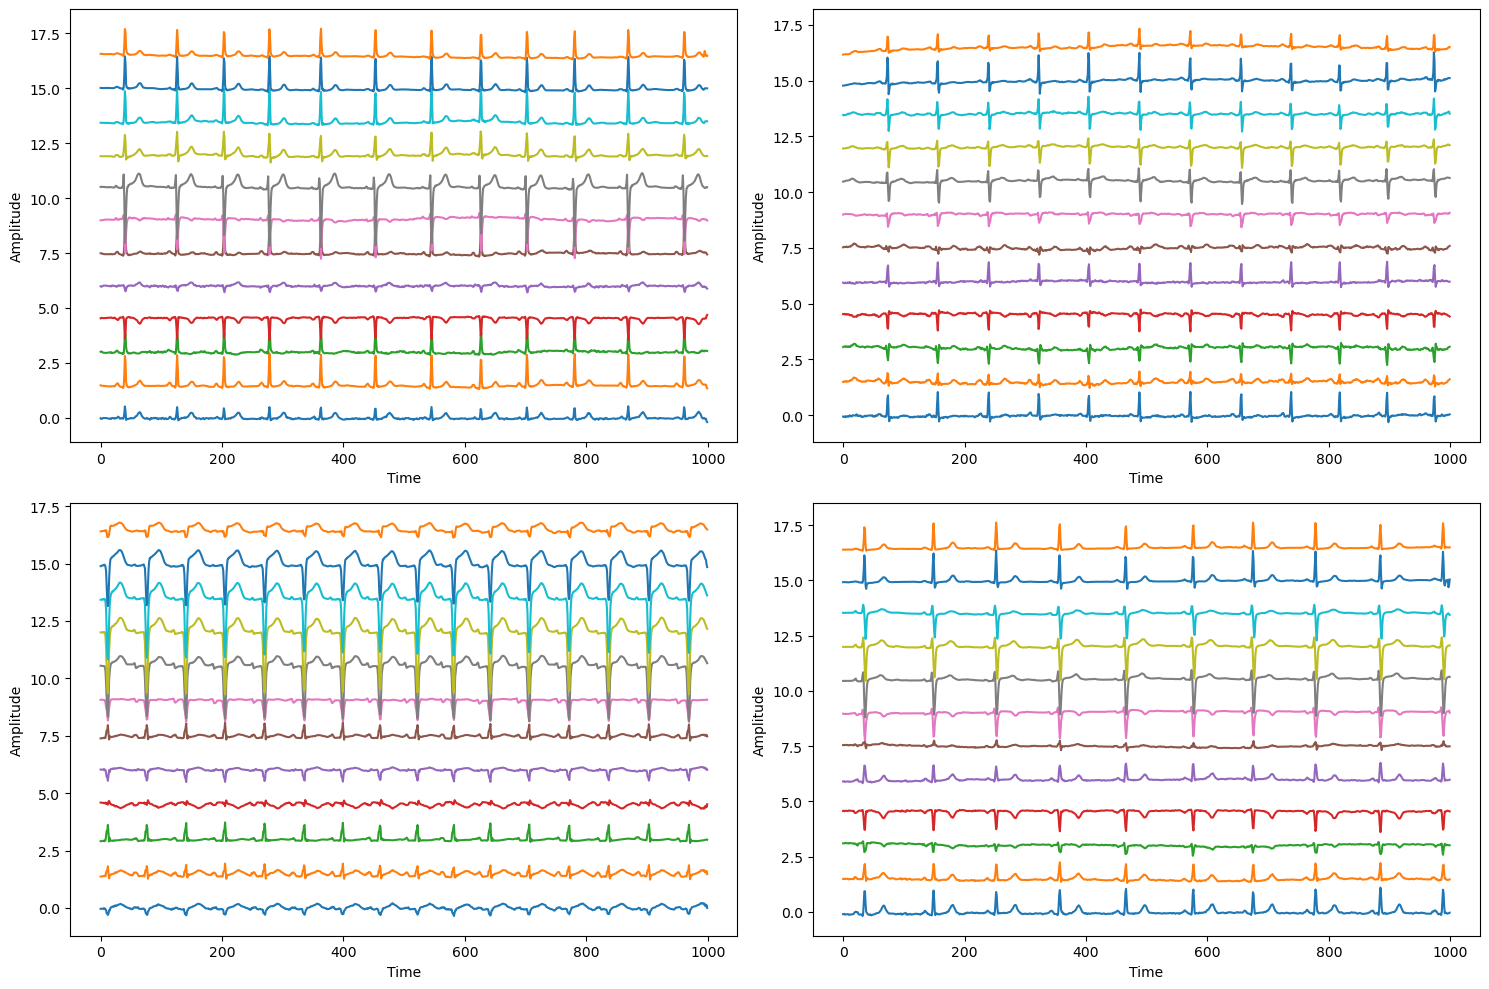

Sample 0: Ultraclass: NORM, Superclass: NORM, Subclass: NORM
Sample 1: Ultraclass: OTHERS, Superclass: STTC, Subclass: STTC
Sample 2: Ultraclass: OTHERS, Superclass: CD MI HYP, Subclass: _AVB LAO/LAE AMI
Sample 3: Ultraclass: NORM, Superclass: NORM, Subclass: NORM


In [53]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ecg(signal, ultraclass_label, superclass_label, subclass_label, ax):
    for i in range(signal.shape[1]):  
        ax.plot(signal[:, i] + i * 1.5, label=f'Lead {i+1}') 
  #  ax.set_title(f'ECG Signal - Ultraclass: {ultraclass_label}, Superclass: {superclass_label}, Subclass: {subclass_label}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')

dataiter = iter(trainloader)
data = next(dataiter)
signals = data['ecg']
ultraclass_labels, superclass_labels, subclass_labels = data['label']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))  
for idx, ax in enumerate(axes.flat):
    plot_ecg(signals[idx], ultraclass_labels[idx], superclass_labels[idx], subclass_labels[idx], ax)

plt.tight_layout()  
plt.show()

for j in range(4):
    ultraclass_names = [ultraclass_classes[k] for k in range(ultraclass_labels.shape[1]) if ultraclass_labels[j, k] == 1]
    superclass_names = [superclass_classes[k] for k in range(superclass_labels.shape[1]) if superclass_labels[j, k] == 1]
    subclass_names = [subclass_classes[k] for k in range(subclass_labels.shape[1]) if subclass_labels[j, k] == 1]
    print(f'Sample {j}: Ultraclass: {" ".join(ultraclass_names)}, Superclass: {" ".join(superclass_names)}, Subclass: {" ".join(subclass_names)}')

In [54]:
signals = signals.transpose(1, 2)  
signals = signals.to('cuda', non_blocking=True)  
ultraclass_labels = ultraclass_labels.to('cuda', non_blocking=True)
superclass_labels = superclass_labels.to('cuda', non_blocking=True)
subclass_labels = subclass_labels.to('cuda', non_blocking=True)

outputs = model(signals)

ultraclass_logits, superclass_logits, subclass_logits = outputs

ultraclass_preds = torch.sigmoid(ultraclass_logits) > 0.5
superclass_preds = torch.sigmoid(superclass_logits) > 0.5
subclass_preds = torch.sigmoid(subclass_logits) > 0.5

In [55]:
def get_class_names(encoded_labels, classes):
    return [classes[k] for k in range(len(encoded_labels)) if encoded_labels[k] == 1]

for j in range(signals.shape[0]):  
    real_ultraclass_names = get_class_names(ultraclass_labels[j].tolist(), classes['ultraclass'])
    real_superclass_names = get_class_names(superclass_labels[j].tolist(), classes['superclass'])
    real_subclass_names = get_class_names(subclass_labels[j].tolist(), classes['subclass'])
    
    pred_ultraclass_names = get_class_names(ultraclass_preds[j].tolist(), classes['ultraclass'])
    pred_superclass_names = get_class_names(superclass_preds[j].tolist(), classes['superclass'])
    pred_subclass_names = get_class_names(subclass_preds[j].tolist(), classes['subclass'])
    
    print(f'Sample {j}:')
    print(f'  Real Ultraclass: {" ".join(real_ultraclass_names)} | Predicted Ultraclass: {" ".join(pred_ultraclass_names)}')
    print(f'  Real Superclass: {" ".join(real_superclass_names)} | Predicted Superclass: {" ".join(pred_superclass_names)}')
    print(f'  Real Subclass: {" ".join(real_subclass_names)} | Predicted Subclass: {" ".join(pred_subclass_names)}')

Sample 0:
  Real Ultraclass: NORM | Predicted Ultraclass: NORM
  Real Superclass: NORM | Predicted Superclass: NORM
  Real Subclass: NORM | Predicted Subclass: NORM
Sample 1:
  Real Ultraclass: OTHERS | Predicted Ultraclass: OTHERS
  Real Superclass: STTC | Predicted Superclass: STTC
  Real Subclass: STTC | Predicted Subclass: 
Sample 2:
  Real Ultraclass: OTHERS | Predicted Ultraclass: OTHERS
  Real Superclass: CD MI HYP | Predicted Superclass: CD
  Real Subclass: _AVB LAO/LAE AMI | Predicted Subclass: 
Sample 3:
  Real Ultraclass: NORM | Predicted Ultraclass: NORM
  Real Superclass: NORM | Predicted Superclass: NORM
  Real Subclass: NORM | Predicted Subclass: NORM


In [37]:
import torch.nn as nn
import torch.nn.functional as F

In [38]:
X.shape

(21799, 1000, 12)

In [39]:
batch_size = 128
num_input_channels = 12
num_timepoints = 1000
x = torch.randn(batch_size, num_input_channels, num_timepoints)
print (x.shape)

num_output_channels = 24
kernel_size = 3
stride = 1
padding = 1

num_ultraclasses = 2
num_superclasses = 5
num_subclasses = 23

torch.Size([128, 12, 1000])


In [40]:
class MultiLabelSoftMarginLoss(nn.Module):
    def __init__(self, label_smoothing=0.0, reduction='mean'):
        super(MultiLabelSoftMarginLoss, self).__init__()
        assert 0 <= label_smoothing < 1, "label_smoothing value must be between 0 and 1."
        self.label_smoothing = label_smoothing
        self.reduction = reduction
        self.multi_label_soft_margin = nn.MultiLabelSoftMarginLoss(reduction=reduction)

    def forward(self, input, target):
        if self.label_smoothing > 0:
            # Calculate smoothed labels
            num_classes = target.size(1)  # Assumes target is [batch_size, num_classes]
            positive_smoothed_labels = 1.0 - self.label_smoothing
            negative_smoothed_labels = self.label_smoothing / (num_classes - 1)
            smoothed_target = target * positive_smoothed_labels + (1 - target) * negative_smoothed_labels
            target = smoothed_target

        loss = self.multi_label_soft_margin(input, target)
        return loss

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.checkpoint import checkpoint

class HierarchicalMLP(nn.Module):
    def __init__(self, num_input_channels, num_ultraclasses, num_superclasses, num_subclasses, num_output_channels=16, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv1 = nn.Conv1d(num_input_channels, num_output_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm1d(num_output_channels)
        self.conv2 = nn.Conv1d(num_output_channels, 2 * num_output_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm1d(2 * num_output_channels)
        self.conv3 = nn.Conv1d(2 * num_output_channels, 4 * num_output_channels, kernel_size, stride, padding)
        self.bn3 = nn.BatchNorm1d(4 * num_output_channels)
        self.pool = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(16000, 128)
        self.fc_ultraclass = nn.Linear(128, num_ultraclasses)
        self.fc_superclass = nn.Linear(128 + num_ultraclasses, num_superclasses)
        self.fc_subclass = nn.Linear(128 + num_ultraclasses + num_superclasses, num_subclasses)  # Subclass output depends on superclass

    def forward(self, x):
        def first_block(x):
            x = self.conv1(x)
            x = self.bn1(x)
            x = F.relu(x)
            return x
        
        def second_block(x):
            x = self.conv2(x)
            x = self.bn2(x)
            x = F.relu(x)
            x = self.pool(x)
            return x
        
        def third_block(x):
            x = self.conv3(x)
            x = self.bn3(x)
            x = F.relu(x)
            x = self.pool(x)
            return x

        x = checkpoint(first_block, x)
        x = checkpoint(second_block, x)
        x = checkpoint(third_block, x)
        
        x = self.flatten(x)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))

        ultraclass_logits = self.fc_ultraclass(x)
        combined_input = torch.cat((x, ultraclass_logits), dim=1)
        superclass_logits = self.fc_superclass(combined_input)
        combined_input2 = torch.cat((combined_input, superclass_logits), dim=1)
        subclass_logits = self.fc_subclass(combined_input2)

        return ultraclass_logits, superclass_logits, subclass_logits

In [46]:
model = HierarchicalMLP(num_input_channels, num_ultraclasses, num_superclasses, num_subclasses)
ultraclass_output, superclass_output, subclass_output = model(x)

In [44]:
import torch.optim as optim
model = model.cuda()
model = torch.compile(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

torch.cuda.empty_cache()

for epoch in range(5):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs = data['ecg'].to('cuda', non_blocking=True)
        labels = data['label']
        ultraclass_labels, superclass_labels, subclass_labels = labels
        
        inputs = inputs.transpose(1, 2)
        ultraclass_labels = ultraclass_labels.to('cuda', non_blocking=True)
        superclass_labels = superclass_labels.to('cuda', non_blocking=True)
        subclass_labels = subclass_labels.to('cuda', non_blocking=True)
        
        optimizer.zero_grad()

        ultraclass_logits, superclass_logits, subclass_logits = model(inputs)
        loss_ultraclass = criterion(ultraclass_logits, ultraclass_labels)
        loss_superclass = criterion(superclass_logits, superclass_labels)
        loss_subclass = criterion(subclass_logits, subclass_labels)

        total_loss = loss_ultraclass + loss_superclass + loss_subclass
        
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()
        if (i + 1) % 2000 == 0:    
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.398
[1,  4000] loss: 1.189
[2,  2000] loss: 1.119
[2,  4000] loss: 1.080
[3,  2000] loss: 1.035
[3,  4000] loss: 1.037
[4,  2000] loss: 0.990
[4,  4000] loss: 0.989
[5,  2000] loss: 0.960
[5,  4000] loss: 0.935
Finished Training


In [47]:
import torch.optim as optim

model = model.cuda()
model = torch.compile(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

torch.cuda.empty_cache()

for epoch in range(5):
    model.train()
    running_loss_ultraclass = 0.0
    running_loss_superclass = 0.0
    running_loss_subclass = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs = data['ecg'].to('cuda', non_blocking=True)
        labels = data['label']
        ultraclass_labels, superclass_labels, subclass_labels = labels
        
        inputs = inputs.transpose(1, 2)
        ultraclass_labels = ultraclass_labels.to('cuda', non_blocking=True)
        superclass_labels = superclass_labels.to('cuda', non_blocking=True)
        subclass_labels = subclass_labels.to('cuda', non_blocking=True)
        
        optimizer.zero_grad()

        ultraclass_logits, superclass_logits, subclass_logits = model(inputs)
        loss_ultraclass = criterion(ultraclass_logits, ultraclass_labels)
        loss_superclass = criterion(superclass_logits, superclass_labels)
        loss_subclass = criterion(subclass_logits, subclass_labels)

        total_loss = loss_ultraclass + loss_superclass + loss_subclass
        
        total_loss.backward()
        optimizer.step()

        running_loss_ultraclass += loss_ultraclass.item()
        running_loss_superclass += loss_superclass.item()
        running_loss_subclass += loss_subclass.item()

        if (i + 1) % 2000 == 0:
            print(f'[{epoch + 1}, {i + 1:5d}] ultraclass loss: {running_loss_ultraclass / 2000:.3f}')
            print(f'[{epoch + 1}, {i + 1:5d}] superclass loss: {running_loss_superclass / 2000:.3f}')
            print(f'[{epoch + 1}, {i + 1:5d}] subclass loss: {running_loss_subclass / 2000:.3f}')
            running_loss_ultraclass = 0.0
            running_loss_superclass = 0.0
            running_loss_subclass = 0.0

print('Finished Training')

[1,  2000] ultraclass loss: 0.627
[1,  2000] superclass loss: 0.536
[1,  2000] subclass loss: 0.249
[1,  4000] ultraclass loss: 0.540
[1,  4000] superclass loss: 0.474
[1,  4000] subclass loss: 0.176
[2,  2000] ultraclass loss: 0.501
[2,  2000] superclass loss: 0.448
[2,  2000] subclass loss: 0.165
[2,  4000] ultraclass loss: 0.479
[2,  4000] superclass loss: 0.436
[2,  4000] subclass loss: 0.161
[3,  2000] ultraclass loss: 0.453
[3,  2000] superclass loss: 0.416
[3,  2000] subclass loss: 0.156
[3,  4000] ultraclass loss: 0.455
[3,  4000] superclass loss: 0.417
[3,  4000] subclass loss: 0.156
[4,  2000] ultraclass loss: 0.440
[4,  2000] superclass loss: 0.403
[4,  2000] subclass loss: 0.152
[4,  4000] ultraclass loss: 0.426
[4,  4000] superclass loss: 0.397
[4,  4000] subclass loss: 0.152
[5,  2000] ultraclass loss: 0.415
[5,  2000] superclass loss: 0.381
[5,  2000] subclass loss: 0.147
[5,  4000] ultraclass loss: 0.416
[5,  4000] superclass loss: 0.387
[5,  4000] subclass loss: 0.149


In [48]:
correct_ultraclass = 0
correct_superclass = 0
correct_subclass = 0
total_ultraclass = 0
total_superclass = 0
total_subclass = 0

with torch.no_grad():
    for data in testloader:
        inputs = data['ecg'].to('cuda', non_blocking=True)
        labels = data['label']
        inputs = inputs.transpose(1, 2)
        ultraclass_labels, superclass_labels, subclass_labels = labels
        ultraclass_labels = ultraclass_labels.to('cuda', non_blocking=True)
        superclass_labels = superclass_labels.to('cuda', non_blocking=True)
        subclass_labels = subclass_labels.to('cuda', non_blocking=True)

        outputs = model(inputs)

        ultraclass_logits, superclass_logits, subclass_logits = outputs

        ultraclass_preds = torch.sigmoid(ultraclass_logits) > 0.5
        superclass_preds = torch.sigmoid(superclass_logits) > 0.5
        subclass_preds = torch.sigmoid(subclass_logits) > 0.5

        correct_ultraclass += (ultraclass_preds == ultraclass_labels).sum()
        correct_superclass += (superclass_preds == superclass_labels).sum()
        correct_subclass += (subclass_preds == subclass_labels).sum()

        total_ultraclass += ultraclass_labels.numel()
        total_superclass += superclass_labels.numel()
        total_subclass += subclass_labels.numel()

accuracy_ultraclass = 100 * correct_ultraclass / total_ultraclass
accuracy_superclass = 100 * correct_superclass / total_superclass
accuracy_subclass = 100 * correct_subclass / total_subclass

print(f'Accuracy for Ultraclass labels: {accuracy_ultraclass:.2f} %')
print(f'Accuracy for Superclass labels: {accuracy_superclass:.2f} %')
print(f'Accuracy for Subclass labels: {accuracy_subclass:.2f} %')

Accuracy for Ultraclass labels: 75.36 %
Accuracy for Superclass labels: 80.65 %
Accuracy for Subclass labels: 95.01 %
